Notes: много категорий с окончанием "_n_s" (похоже неотсортированные картинки).  Например 'meat_n_s', где есть картинки мяса в супе, мяса на пицце и откущеный стейк. Всего в подобных категориях 4.5k изображений. Я пока объединила такие категории с общей категорией по теме, например категорию 'meat_n_s' с категорией "meat", но если модель будет очень плохо тенироваться, возможно имеет смысл такие "грязные" категории просто убрать из датасета.

In [1]:
import json
import os
import pandas as pd
from IPython.display import Image
import altair as alt
import tqdm
import numpy as np

In [2]:
project_path = '/Users/rdyo/code/FoodSnap/'

# Helper functions

In [3]:
colors_dict = {
    "Blue": "#00B7F1",
    "Dark Blue": "#000E4E",
    "Green": "#81BB41",
    "Purple": "#993399",
    "Orange": "#E75424",
    "Medium Light Gray": "#E6E7E8",
    "Light Gray": "#F1F1F2",
    "Dark Gray": "#BEC1C3",
    "White": "#FFFFFF",
    "Black": "#000000",
    "Magenta": "#f653a6",
    "Beigegrau": "#756f61",
    "Blue 2": "#0089b5",
    "Pink": "#c460aa",
    "Dark Green": "#263813",
}

def constantia():
    """
    Configure font and font sizes
    """
    font = "Constantia"

    return {
        "config": {
            "title": {"font": font, "fontSize": 22},
            "axis": {
                "labelFont": font,
                "titleFont": font,
                "labelFontSize": 20,
                "titleFontSize": 26,
            },
            "header": {
                "labelFont": font,
                "titleFont": font,
                "labelFontSize": 20,
                "titleFontSize": 26,
            },
            "legend": {
                "labelFont": font,
                "titleFont": font,
                "labelFontSize": 20,
                "titleFontSize": 26,
            },
            "view": {
                "height": 300,
                "width": 600,
            },
        }
    }


def def_style():
    """
    Define font and some other altair settings
    """

    alt.renderers.enable("default")
    alt.data_transformers.disable_max_rows()
    alt.themes.register("constantia", constantia)
    alt.themes.enable("constantia")
    # print("BY Style applied")

In [4]:
def plot_simple_cat_hist(df, xvar, xlabel, yvar, ylabel):
    """
    Histogram with aggregation per categories
    Parameters:
        df (DataFrame): input dataframe
        xvar (str): name of column with counts
        xlabel (str): title for x-axis
        yvar (str): name of column with categories
        ylabel (str): title for y-axis
    Return:
        altair chart
    """

    def_style()
    chart = (
        alt.Chart(df)
        .mark_bar(color=colors_dict["Blue"], opacity=0.99)
        .encode(
            y=alt.Y(f"{yvar}:O", title=ylabel, sort=alt.EncodingSortField(field=xvar, order="descending")),
            x=alt.X(f"{xvar}:Q", title=xlabel),
            tooltip=[xvar, yvar],
        )
        .interactive()
        .configure_axis(grid=False)
        .configure_view(stroke="transparent")
    )
    return chart


def plot_simple_cat_unordered_hist(df, xvar, xlabel, yvar, ylabel):
    """
    Histogram with aggregation per categories
    Parameters:
        df (DataFrame): input dataframe
        xvar (str): name of column with categories
        xlabel (str): title for x-axis
        yvar (str): name of column with counts
        ylabel (str): title for y-axis
    Return:
        altair chart
    """

    stl.def_style()
    chart = (
        alt.Chart(df)
        .mark_bar(color=colors_dict["Blue"], opacity=0.99)
        .encode(
            x=alt.X(f"{xvar}:O", title=xlabel),
            y=alt.Y(f"{yvar}:Q", title=ylabel),
            tooltip=[f"{yvar}"],
        )
        .interactive()
        .configure_axis(grid=False)
        .configure_view(stroke="transparent")
    )
    return chart


def plot_simple_binned_unordered_hist(
    df, xvar, xlabel, yvar, ylabel, binning=alt.Bin(extent=[0, 6], step=0.2), yscalelog=False
):
    """
    Histogram with aggregation per categories
    Parameters:
        df (DataFrame): input dataframe
        xvar (str): name of column with categories
        xlabel (str): title for x-axis
        yvar (str): name of column with counts
        ylabel (str): title for y-axis
        yscalelog (bool): plot y-axis in log scale
    Return:
        altair chart
    """
    yscale = "log" if yscalelog else "linear"
    stl.def_style()
    chart = (
        alt.Chart(df)
        .mark_bar(color=colors_dict["Blue"], opacity=0.99)
        .encode(
            x=alt.X(f"{xvar}:Q", title=xlabel, bin=binning),
            y=alt.Y(f"{yvar}:Q", title=ylabel, scale=alt.Scale(type=yscale)),
            tooltip=[xvar, yvar],
        )
        .configure_axis(grid=False)
        .configure_view(stroke="transparent")
    )
    return chart


def agg_categories(df, agg="nunique", category="CATEGORY", objects="ProductID"):
    """
    Aggregate per category
    """
    df_categories = df.groupby([category]).agg({objects: agg}).reset_index()
    return df_categories


def plot_category_counts(
    df, category="CATEGORY", category_label="category", objects="ProductID", object_label="ProductID count"
):
    """
    Count of distinct objects per category and show top-10 on the plot
    Parameters:
        df (DataFrame): input dataframe
        category (str): column with categories
        category_label (str): title for x-axis
        object(str): column to count distinct objects in the category
        object_label(str): title for y-axis
    Return:
        altair chart
    """

    df_categories = agg_categories(df, agg="nunique", category=category, objects=objects)
    df_categories = df_categories.sort_values(by=objects, ascending=False).head(15)
    chart = plot_simple_cat_hist(
        df_categories,
        objects,
        object_label,
        category,
        category_label,
    )
    return chart

# Read input data

## Read annotation data

In [5]:
ann_file = project_path+"data/3.0/annotations.json"
annotations = json.load(open(ann_file, 'r'))

In [6]:
annotations.keys()

dict_keys(['info', 'images', 'annotations', 'categories'])

In [7]:
df_images_prop = pd.json_normalize(annotations, record_path =['images'])
df_images_prop.rename(columns={'id':'image_id'},inplace=True)

In [8]:
df_images = pd.json_normalize(annotations, record_path =['annotations'])

In [9]:
df_images = df_images.merge(df_images_prop,on='image_id',how='left')

In [10]:
df_categories = pd.json_normalize(annotations, record_path =['categories'])
df_categories.rename(columns={'id':'category_id','name':'category_name','name_readable':'category_name_readable'},inplace=True)

In [11]:
df_img_annot = df_images[['id','image_id','file_name','width','height','category_id','area']].merge(df_categories,on=['category_id'],how='left')

# Preprocessing

In [12]:
df_img_annot['picture_size'] = df_img_annot['width']*df_img_annot['height']

In [13]:
df_img_annot['category_name_clean'] = df_img_annot['category_name'].str.replace('-','_')
df_img_annot['category_name_clean'].nunique()

581

# Remove duplicates

In [14]:
df_img_annot.shape

(180194, 12)

In [15]:
df_img_annot.drop_duplicates(subset=['image_id','category_id','category_name_clean'],inplace=True)

In [16]:
df_img_annot.shape

(165573, 12)

In [17]:
180194 - 117210

62984

In [18]:
df_img_annot.sample(5)

id  image_id   file_name  width  height  category_id      area  \
89878   154915    109378  109378.jpg    876     875       100334  126449.0   
176431  175507    123585  123585.jpg    392     391         2738    1237.0   
116975   30216     20338  020338.jpg    480     480         3532   71487.0   
10812   222806    143834  143834.jpg    977     977       101254  424877.0   
93621   165408    117120  117120.jpg    775     774       101188  109175.0   

                    category_name      category_name_readable supercategory  \
89878             bread_ticino_ch             bread_ticino_ch          food   
176431               tomato-sauce                Tomato sauce          food   
116975  vegetable-au-gratin-baked  Vegetable au gratin, baked          food   
10812           bread_whole_wheat           bread_whole_wheat          food   
93621                      carrot                      carrot          food   

        picture_size        category_name_clean  
89878         766500            bread_ticino_ch  
176431        153272               tomato_sauce  
116975        230400  vegetable_au_gratin_baked  
10812         954529          bread_whole_wheat  
93621         599850                     carrot

## Remaping

In [19]:
dict = {"tea_ginger" : 'tea', "tea_spice" : 'tea', "tea_fruit": 'tea', "tea_rooibos":'tea',
       'chocolate_filled':'chocolate','tomato_stewed_without_addition_of_fat_without_addition_of_salt':'tomato',
        'zucchini_stewed_without_addition_of_fat_without_addition_of_salt':'zucchini',
        'green_bean_steamed_without_addition_of_salt':'green_bean',
        'hazelnut_chocolate_spread_nutella_ovomaltine_caotina':'hazelnut_chocolate',
        'nutella':'hazelnut_chocolate','light_beer':'beer','pancakes':'pancake',
       'coffee_decaffeinated':'coffee',
        'salt_cake_ch_vegetables_filled':'salt_cake_vegetables_filled',
        'quiche_with_spinach_baked_with_cake_dough':'quiche',
        'quiche_with_cheese_baked_with_puff_pastry':'quiche',
        'lemon_cake':'cake_lemon','pie_plum_baked_with_cake_dough':'pie_cake-dough','pie_rhubarb_baked_with_cake_dough':'pie_cake-dough',
        'pie_apricot_baked_with_cake_dough':'pie_cake-dough', 'pie_plum_baked_with_cake_dough':'pie_cake-dough',
        'salt_cake_vegetables_filled':'cake_salted','milk_chocolate_with_hazelnuts':'milk_chocolate','chocolate_milk_chocolate_drink':'chocolate_milk',
        'milk_chocolate':'chocolate_milk','flakes':'flakes_oat','salad_lambs_ear':'mixed_salad_chopped_without_sauce','salad_rocket':'mixed_salad_chopped_without_sauce',
        'potato_salad_with_mayonnaise_yogurt_dressing':'potato_salad','bread':'bread_white','bread_wholemeal':'bread_whole_wheat','bread_wholemeal_toast':'bread_whole_wheat',
        'bread_5_grain':'bread_whole_wheat','cenovis_yeast_spread':'bread_white',
        'bread_grain':'bread_white','dough_puff_pastry_shortcrust_bread_pizza_dough':'quiche','fish_n_s':'fish',
        'greek_yaourt_yahourt_yogourt_ou_yoghourt':'yogourt','yaourt_yahourt_yogourt_ou_yoghourt_natural':'yogourt',
       'soya_yaourt_yahourt_yogourt_ou_yoghourt':'yogourt','cheese_n_s':'hard_cheese','cheese':'hard_cheese',
        'emmental_cheese_ch':'hard_cheese','emmental_cheese':'hard_cheese','cream_cheese_n_s':'soft_cheese',
        'parmesan':'hard_cheese','gruyere':'hard_cheese',
        'processed_cheese':'hard_cheese','fresh_cheese_n_s':'fresh_cheese','cheese_for_raclette_ch':'soft_cheese',
        'cheese_for_raclette':'soft_cheese',
        'risotto_without_cheese_cooked':'rice','rice_basmati':'rice','rice_jasmin':'rice','rice_wild':'rice',
        'rice_whole_grain':'rice','carrot_raw':'carrot','carrot_steamed_without_addition_of_salt':'carrot',
        'chicken_cut_into_stripes_only_meat':'chicken_breast','chicken':'chicken_breast',
        'applesauce_unsweetened_canned':'applesauce','apple_crumble':'apple_pie',
        'alfa_sprouts':'mungbean_sprouts',
        'cucumber_pickled_ch':'cucumber_pickled','pasta_hornli_ch':'pasta_hornli','salami_ch':'salami',
        'chestnuts_ch':'chestnuts', 'braided_white_loaf_ch':'braided_white_loaf', 
       'tomme_ch':'tomme',  'meatloaf_ch':'meatloaf', 
       'gruyere_ch':'gruyere', 'crisps_ch':'crisps', 'bread_ticino_ch':'bread_ticino', 
        'ham_croissant_ch':'ham_croissant', 'cervelat_ch':'cervelat',
        'beef_n_s':'beef','beef_sirloin_steak':'beef',
       'beef_cut_into_stripes_only_meat':'beef', 'beef_filet':'beef',
       'beef_minced_only_meat':'beef', 'beef_roast':'beef',
       'smoked_cooked_sausage_of_pork_and_beef_meat_sausag':'beef','water_with_lemon_juice':'water',
        'lemon_pie':'cake_lemon','praline_n_s':'chocolate', 'praline':'chocolate','tomato_raw':'tomato',
        'pasta_n_s':'pasta','pasta_noodles':'pasta','pasta_hornli':'pasta', 'pasta_penne':'pasta','pasta_in_conch_form':'pasta',
        'pasta_twist':'pasta','pasta_linguini_parpadelle_tagliatelle':'pasta',
        'pasta_in_butterfly_form_farfalle':'pasta',
        'shrimp_boiled':'shrimp_prawn', 'shrimp_prawn_small':'shrimp_prawn',
       'shrimp_prawn_large':'shrimp_prawn',
        'hamburger_bread_meat_ketchup':'hamburger','cooked_sausage':'sausage',
        'sauce_savoury_n_s':'sauce_savoury','sauce_sweet_salted_asian':'sauce_sweet_sour',
        'pearl_onion':'onion', 'pearl_onions':'onion',
        'tea_peppermint':'herbal_tea','tea_verveine':'herbal_tea',
        'ice_tea_on_black_tea_basis':'ice_tea',
       'mix_of_dried_fruits_and_nuts':'mixed_nuts','egg_scrambled_prepared':'egg_scrambled',
        'eggplant':'aubergine_eggplant','eggplant_caviar':'aubergine_eggplant',
        'leaf_spinach':'spinach', 'spinach_raw':'spinach', 'cream_spinach':'spinach',
       'spinach_steamed_without_addition_of_salt':'spinach',
        'ice_cream_n_s':'ice_cream', 'dairy_ice_cream':'ice_cream',
        'white_coffee_with_caffeine':'white_coffee', 'coffee_with_caffeine':'coffee',
        'cola_based_drink':'coca_cola','coca_cola_zero':'coca_cola','chocolate_n_s':'chocolate',
        'butter_herb':'butter','muesli':'muesli_dry','birchermuesli_prepared_no_sugar_added':'muesli_dry',
        'red_cabbage_raw':'red_cabbage','savoy_cabbage_steamed_without_addition_of_salt':'chinese_cabbage',
        'espresso':'coffee', 'espresso_with_caffeine':'coffee','ristretto_with_caffeine':'coffee',
        'pork_n_s':'pork','pork_roast':'pork', 'pork_chop':'pork',
        'ham_raw':'ham', 'ham_n_s':'ham', 'lentil_n_s':'lentil',
        'tart_n_s':'quiche', 'dried_meat_n_s':'dried_meat', 'rosti_n_s':'rosti',
       'meat_n_s':'meat', 'seeds_n_s':'seeds', 'berries_n_s':'berries', 'mixed_seeds_n_s':'mixed_seeds',
       'aperitif_with_alcohol_n_s_aperol_spritz':'aperol_spritz', 'shoots_n_s':'shoots','aperitif_with_alcohol_aperol_spritz':'aperol_spritz',
        'sauce_cream':'cream', 'cream_double_cream_heavy_cream_45':'sour_cream',
        'vanille_cream_cooked_custard_creme_dessert':'ice_cream','omelette_with_flour_thick_crepe_plain':'omelette', 
        'omelette_plain':'omelette','bell_pepper_red_stewed':'bell_pepper_red',
       'mushroom_average_stewed_without_addition_of_fat_without_addition_of_salt':'mushrooms','mushroom':'mushrooms',
       'bell_pepper_red_stewed_without_addition_of_fat_without_addition_of_salt':'bell_pepper_red',
        'risotto_with_mushrooms_cooked':'rice','curds_natural_with_at_most_10_fidm':'curd'
       }
df_img_annot["category_name_clean"].replace(dict, inplace=True)

In [20]:
df_img_annot['category_name_clean'].value_counts()

category_name_clean
water                     7644
bread_white               6449
bread_whole_wheat         5161
coffee                    5042
salad_leaf_salad_green    4871
                          ... 
mango_dried                 18
bagel_without_filling       17
oat_milk                    17
buckwheat_pancake           17
oil                         13
Name: count, Length: 439, dtype: int64

In [21]:
df_img_annot['category_name_clean'].nunique()

439

### Select subcategory

In [22]:
df_img_annot['category_name_clean'].sample(1)

29772    water
Name: category_name_clean, dtype: object

In [23]:
mask = df_img_annot['category_name_clean'].str.contains('mushroom')
df_img_annot[mask]['category_name_clean'].unique()

array(['mushrooms', 'sauce_mushroom',
       'pizza_with_ham_with_mushrooms_baked'], dtype=object)

### Check pictures

Number of pictures in the category 854


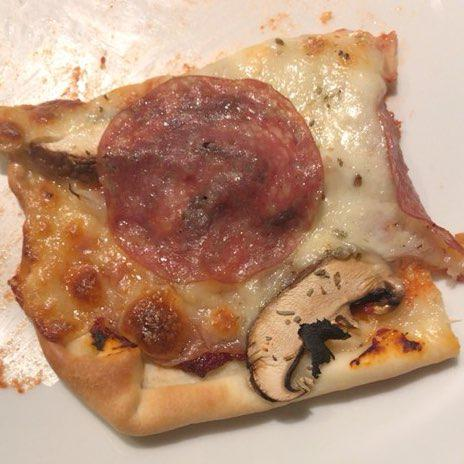

In [24]:
category = 'mushrooms'
mask = df_img_annot['category_name_clean']==category
print("Number of pictures in the category",len(df_img_annot[mask]))
img_path = project_path+"data/3.0/images/"
img_file = img_path+df_img_annot[mask]['file_name'].values[0]
Image(filename=img_file) 

# Write the annotation file

In [25]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df_img_annot['category_code_clean'] = LE.fit_transform(df_img_annot['category_name_clean'])

In [26]:
df_img_annot.sample(3)

id  image_id   file_name  width  height  category_id      area  \
126689   53812     30997  030997.jpg   1081    1080         2320  469297.0   
31515   260430    160231  160231.jpg    627     627       100130   76960.0   
158448  122352     81088  081088.jpg   1010    1010         1565   75148.0   

          category_name category_name_readable supercategory  picture_size  \
126689   omelette-plain        Omelette, plain          food       1167480   
31515             apple                  apple          food        393129   
158448  bread-wholemeal       Bread, wholemeal          food       1020100   

       category_name_clean  category_code_clean  
126689            omelette                  276  
31515                apple                    3  
158448   bread_whole_wheat                   61

In [27]:
df_img_annot['category_code_clean'].nunique(),df_img_annot['category_name_clean'].nunique()

(439, 439)

In [28]:
df_category_mapping = df_img_annot.groupby('category_id').agg({'category_name_clean':'first','category_code_clean':'first'}).reset_index()
df_category_mapping.sample(3)

category_id category_name_clean  category_code_clean
219         1565   bread_whole_wheat                   61
590       100302            couscous                  128
115         1199       dried_raisins                  153

In [29]:
annotations.keys()

dict_keys(['info', 'images', 'annotations', 'categories'])

In [30]:
len(annotations['annotations'])

180194

## Overwrite values in annotations json

In [31]:
for i in range(len(annotations['annotations'])):
    mask = (df_category_mapping['category_id'] == int(annotations['annotations'][i]['category_id']))
    if(len(df_category_mapping[mask]['category_code_clean'])>0):
        annotations['annotations'][i]['category_id'] = df_category_mapping[mask]['category_code_clean'].values[0]
    else:
        print(annotations['annotations'][i])

In [32]:
annotations['annotations'][0].keys()

dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd'])

In [33]:
len(annotations['annotations'])

180194

In [34]:
ann_new_dict = []
temp_ann = []
counter_id = 0
for i in tqdm.tqdm(range(len(annotations['annotations']))):
    if {annotations['annotations'][i]['image_id'],annotations['annotations'][i]['category_id']} not in temp_ann:
        temp_ann.append({annotations['annotations'][i]['image_id'],annotations['annotations'][i]['category_id']})
        ann_new_dict.append({
                            #'id':annotations['annotations'][i]['id'], 
                            'id':counter_id,
                            'image_id':annotations['annotations'][i]['image_id'], 
                            'category_id':annotations['annotations'][i]['category_id'], 
                            'segmentation':annotations['annotations'][i]['segmentation'], 
                            'area':annotations['annotations'][i]['area'], 
                            'bbox':annotations['annotations'][i]['bbox'], 
                            'iscrowd':annotations['annotations'][i]['iscrowd']})
        counter_id = counter_id+1
annotations['annotations'] = ann_new_dict

100%|██████████████████████████████████████████████████████████| 180194/180194 [10:33<00:00, 284.30it/s]


In [35]:
len(annotations['annotations'])

103856

In [36]:
#annotations['annotations'][0]

In [37]:
len(annotations['categories'])

820

In [38]:
for i in tqdm.tqdm(range(len(annotations['categories']))):
    mask = (annotations['categories'][i]['id'] == df_category_mapping['category_id'])
    if(len(df_category_mapping[mask]['category_code_clean'])>0):
        annotations['categories'][i]['id'] = df_category_mapping[mask]['category_code_clean'].values[0]
        annotations['categories'][i]['name'] = df_category_mapping[mask]['category_name_clean'].values[0]
        annotations['categories'][i]['name_readable'] = df_category_mapping[mask]['category_name_clean'].values[0]
    else:
        print(annotations['categories'])

100%|███████████████████████████████████████████████████████████████| 820/820 [00:00<00:00, 1529.55it/s]


In [39]:
annotations['categories'][0]

{'id': 29,
 'name': 'beetroot_steamed_without_addition_of_salt',
 'name_readable': 'beetroot_steamed_without_addition_of_salt',
 'supercategory': 'food'}

In [40]:
cat_new_dict = []
temp_cat = []
for i in tqdm.tqdm(range(len(annotations['categories']))):
    if annotations['categories'][i]['id'] not in temp_cat:
        temp_cat.append(annotations['categories'][i]['id'])
        cat_new_dict.append({'id':annotations['categories'][i]['id'],
                            'name':annotations['categories'][i]['name'],
                            'name_readable':annotations['categories'][i]['name_readable'],
                            'supercategory': 'food'})
annotations['categories'] = cat_new_dict

100%|█████████████████████████████████████████████████████████████| 820/820 [00:00<00:00, 242086.95it/s]


In [41]:
len(annotations['categories'])

439

In [42]:
annotations['categories'][0]

{'id': 29,
 'name': 'beetroot_steamed_without_addition_of_salt',
 'name_readable': 'beetroot_steamed_without_addition_of_salt',
 'supercategory': 'food'}

In [43]:
annotations.keys()

dict_keys(['info', 'images', 'annotations', 'categories'])

# Check as in detectron2

In [44]:
anns_per_image = annotations['annotations']
ann_ids = [ann["id"] for ann in anns_per_image]
# assert len(set(ann_ids)) == len(ann_ids), "Annotation ids in '{}' are not unique!".format(
#             json_file
#         )

In [45]:
len(set(ann_ids)),len(ann_ids)

(103856, 103856)

### Write the final json file

In [46]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [47]:
# Serializing json
json_object = json.dumps(annotations,cls=NpEncoder)

In [48]:
# Writing to sample.json
with open("fixed_annotations.json", "w") as outfile:
    outfile.write(json_object)